Making a nice photmetry plot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:412: RuntimeWarning: invalid value encountered in float_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


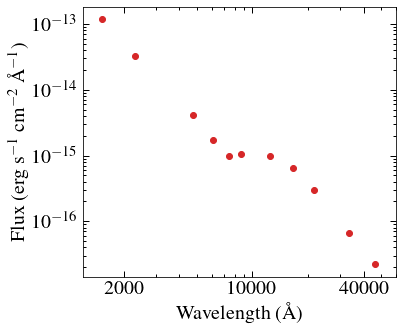

In [60]:
from astropy.io.votable import parse
tphot = 'cc_cet_vizier_votable.vot'
c = 2.998e8*u.m/u.s

plt.figure(figsize=(6,5))

votable = parse(tphot)
table = votable.get_first_table()
data = table.array
mask = ~data['sed_eflux'].mask
masked_data = data[mask].data
filters = np.unique(masked_data['sed_filter'].data)
w = []
f = []
e = []
#print(filters)

filters = [b'2MASS:H', b'2MASS:J', b'2MASS:Ks', b'GALEX:FUV',
           b'GALEX:NUV', b'Gaia:G', b'Johnson:B', b'Johnson:H', b'Johnson:J',
           b'Johnson:K', b'Johnson:V', b'PAN-STARRS/PS1:g', b'PAN-STARRS/PS1:i',
           b'PAN-STARRS/PS1:r', b'PAN-STARRS/PS1:y', b'PAN-STARRS/PS1:z', b"SDSS:g'", 
           b"SDSS:r'", b'WISE:W1', b'WISE:W2'] #picking my own

filters = [b'2MASS:H', b'2MASS:J', b'2MASS:Ks', b'GALEX:FUV',
           b'GALEX:NUV', b'PAN-STARRS/PS1:g', b'PAN-STARRS/PS1:i',
           b'PAN-STARRS/PS1:r', b'PAN-STARRS/PS1:y', b'PAN-STARRS/PS1:z', b'WISE:W1', b'WISE:W2'] #picking my own

#filters = [b'GALEX:NUV']


for flt in filters:
    w1 = (np.mean(masked_data['sed_freq'][masked_data['sed_filter']==flt])*u.GHz).to(u.AA, equivalencies=u.spectral())
    fj1 = masked_data['sed_flux'][masked_data['sed_filter']==flt]
    e1 = masked_data['sed_eflux'][masked_data['sed_filter']==flt]
    if len(fj1) >1:
        fj_av = np.average(fj1, weights = (1/(e1**2)))
        e1_av = abs(np.average((fj1-fj_av), weights = (1/(e1**2))))**0.5
        e1_av = 1 / np.sum(1/(e1**2), axis=0)**0.5
    else:
        fj_av, e1_av = fj1[0], e1[0]
   # print(fj1)
   # print(fj_av)
   # print(e1_av)
    f1 = (fj_av*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(w1)) 
    w.append(w1.value)
    f.append(f1.value)
   # print(e1)
    e1 = ((e1_av*f1)/fj_av).value
    e.append(e1)
   # print(flt, w1, f1, e1)
# plt.figure('sed', figsize=(5,5))
#print(f)
w, f, e = np.array(w), np.array(f), np.array(e)
plt.errorbar(w[e>0], f[e>0], yerr=e[e>0], marker='o', ls='none', c='C3')

#print(filters["2MASS" in filters])

#for i in range(len(w)):
 #   if e[i] !=0.0:
        #plt.errorbar(w[i].value, f[i].value, yerr=e[i].value, marker='o', ls='none', label = filters[i], c='C0', label='Vizer')
  #      
   # else:
    #    plt.errorbar(w[i].value, f[i].value, yerr=f[i].value*0.1, marker='o', ls='none', uplims=True,label = filters[i])
plt.yscale('log')
plt.xscale('log')

#plt.errorbar(gpw, gpf, yerr=gpe, marker='o', ls='none', c='C1', label=r'G+19')
#plt.errorbar(gpw, fake_phot, marker='o', ls='none', c='C2', label='Model')
#plt.ylim(1e-14)
#plt.xlim(1000, 3000)
#plt.legend()
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.xlabel('Wavelength (\AA)')

normfac = 3.78247978e+30
mw, mf = np.loadtxt('models/ldlc01010.dk', unpack=True, skiprows=34)
#plt.plot(mw[mw>1400] , mf[mw>1400]/normfac)
plt.xlim(1200, 60000)
plt.xticks((2000, 10000, 40000), ('2000', '10000', '40000'))
plt.tight_layout()     
#plt.axvline(2311)
plt.savefig('plots/cc_cet_phot.png', dpi=150, facecolor='white')